In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
import os

%matplotlib inline

In [ ]:
def build_montages(image_list, image_shape, montage_shape):
    """
    ---------------------------------------------------------------------------------------------
    author: Kyle Hounslow
    ---------------------------------------------------------------------------------------------
    Converts a list of single images into a list of 'montage' images of specified rows and columns.
    A new montage image is started once rows and columns of montage image is filled.
    Empty space of incomplete montage images are filled with black pixels
    ---------------------------------------------------------------------------------------------
    :param image_list: python list of input images
    :param image_shape: tuple, size each image will be resized to for display (width, height)
    :param montage_shape: tuple, shape of image montage (width, height)
    :return: list of montage images in numpy array format
    ---------------------------------------------------------------------------------------------
    example usage:
    # load single image
    img = cv2.imread('lena.jpg')
    # duplicate image 25 times
    num_imgs = 25
    img_list = []
    for i in xrange(num_imgs):
        img_list.append(img)
    # convert image list into a montage of 256x256 images tiled in a 5x5 montage
    montages = make_montages_of_images(img_list, (256, 256), (5, 5))
    # iterate through montages and display
    for montage in montages:
        cv2.imshow('montage image', montage)
        cv2.waitKey(0)
    ----------------------------------------------------------------------------------------------
    """
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

In [2]:
def build_montage(img_square_s, img_square_l, img_tall, img_wide, mask=False):
    """Generate a montage image with size of 224x224

    Args:
        img_square_s: input image will be resize to 
            small square image with size 64x64
        img_square_l: input image will be resize to 
            large square image with size 64x64160x160
        img_tall: input image will be resize to 
            tall image with size 160x64 
        img_wide: input image will be resize to 
            wide square image with size 64x160
        mask: False if inputs are images, 
            True if inputs are segmentation masks

    Returns:
        montage_image: the montage image with channel=3 if mask=False,
            channel=1 of mask=True
    """
    # Start with black canvas to draw images onto
    if mask:
        montage_image = np.zeros(shape=(224, 224), dtype=np.uint8)
    else:
        montage_image = np.zeros(shape=(224, 224, 3), dtype=np.uint8)

    # Resize images for montage
    top_left_img = cv2.resize(img_square_s, (64, 64))
    top_right_img = cv2.resize(img_wide, (160, 64))
    bottom_left_img = cv2.resize(img_tall, (64, 160))
    bottom_right_img = cv2.resize(img_square_l, (160, 160))

    montage_image[0:64, 0:64] = top_left_img
    montage_image[64:, 0:64] = bottom_left_img
    montage_image[0:64:, 64:] = top_right_img
    montage_image[64:, 64:] = bottom_right_img

    return montage_image

In [6]:
img1 = cv2.imread('ADE20K-custom/annotations/training/ADE_train_00008041.png', cv2.IMREAD_ANYDEPTH)
img2 = cv2.imread('ADE20K-custom/annotations/training/ADE_train_00012975.png', cv2.IMREAD_ANYDEPTH)
img3 = cv2.imread('ADE20K-custom/annotations/training/ADE_train_00009141.png', cv2.IMREAD_ANYDEPTH)
img4 = cv2.imread('ADE20K-custom/annotations/training/ADE_train_00007405.png', cv2.IMREAD_ANYDEPTH)

In [7]:
a = build_montage(img1, img2, img3, img4, mask=True)

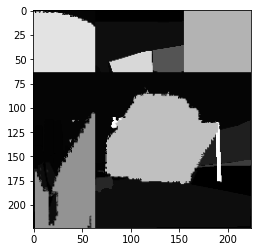

In [9]:
# a = a[:, :, ::-1]
plt.imshow(a, cmap="gray")
plt.show()

### Test segment error

In [3]:
from mmseg.apis import init_segmentor, inference_segmentor
from mmseg.core.evaluation import get_classes
from utils import crop_object, get_image_data
from scipy.stats import entropy
import os.path as osp
import numpy as np
import torch
import cv2
import os


config_file = 'configs/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k.py'
checkpoint_file = 'checkpoints/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth'


model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
classes = get_classes('ade20k')
class2label = {cls: i for i, cls in enumerate(classes)}

image = cv2.imread("crawl_images/escalator/000006.jpg") 

object_id = class2label["escalator"]
# Segmentation
alpha = 0.2
data = get_image_data(model, "crawl_images/escalator/000006.jpg")
with torch.no_grad():
    class_softmax = model.inference(data['img'][0], data['img_metas'][0], True)
output = class_softmax.argmax(dim=1)
# Apply entropy threshold to keep confident pixels
class_entropy = entropy(class_softmax.cpu(), axis=1)
threshold = np.percentile(class_entropy.flatten(), 100 * (1 - alpha))
refine = np.where(class_entropy[0] < threshold, 1, 0)
refine_output = output.cpu() * refine
object_mask = np.where(refine_output == object_id, object_id, 0)
# Skip if object pixels is too little compared to whole image
obj_pixel_ratio = np.sum(object_mask != 0) / (object_mask.shape[0] * object_mask.shape[1])

load checkpoint from local path: checkpoints/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth


In [4]:
cropped_images, cropped_masks = crop_object(image, object_mask, object_id)

error: OpenCV(4.6.0) /io/opencv/modules/core/src/copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'copyMakeBorder'


In [9]:
item_mask = object_mask == object_id

In [11]:
import matplotlib.pyplot as plt

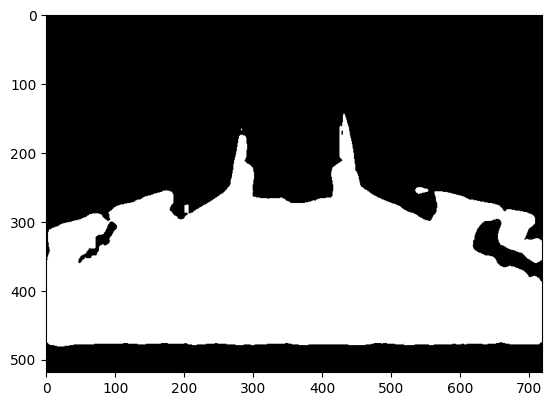

In [13]:
plt.imshow(item_mask[0], cmap="gray")